In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines
import os
from IPython.display import display
import networkx as nx
import statistics
import scipy.stats as st
from sklearn.metrics import jaccard_score
from haversine import haversine
import math

In [2]:
df_martix = pd.read_csv('./study_data/cities_gzh_aja_martix.csv')
df_citys = pd.read_csv('./study_data/sa340.csv')
df_martix.set_index('city', inplace=True)
rank = pd.read_csv('./study_data/score/城市信息+排名得分综合表.csv')
df_in_out = pd.read_csv('./study_data/all_cities_in_out_count.csv')

In [3]:
rank.columns

Index(['citycode', 'adcode', 'name', 'level', 'center', 'pro_name',
       'pro_adcode', 'gzh', 'city_shortname', 'pro_shortname', 'en_name',
       'in_citation', 'citation_score', 'pagerank_value', 'pagerank_rank',
       'importance_score', 'pagerank_score', 'Longitude', 'Latitude', 'ARI',
       'GEO', 'HAR'],
      dtype='object')

In [4]:
# 可视化配置
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# Inter-city Analysis in Province

In [5]:
# cityA 提及 cityB 的次数
def show_A_cite_B_times(cityA, cityB):
    v = df_martix.loc[cityA, cityB]
    return v

In [6]:
def show_cite_times_by_province(pro_name):
    df_pro = df_citys[df_citys.pro_name==pro_name]
    cities_list = df_pro['name'].tolist()
    
    datas = []
    for i in cities_list:
        for j in cities_list:
            if i != j:
                v = show_A_cite_B_times(i, j)
                source = i
                target = j
                datas.append([i, j, int(v)])
                
    temp = pd.DataFrame(datas, columns=['source', 'target', 'weight'])
    return temp

In [10]:
def show_heatmap(df, name):
    plt.figure(figsize=(8, 6))
    FZ_NUM = 13
    FZ = 14
    
    custom_colors = ['#FBE6B3', '#ff0000']
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors)
    
    ax = sns.heatmap(df, cmap=custom_cmap, annot=True, fmt='d', annot_kws={"size": FZ_NUM})
   
    plt.ylabel('City Name', fontsize=FZ, fontweight='bold')
    plt.xlabel('City Name', fontsize=FZ, fontweight='bold')
    
    
    ax.tick_params(axis='x', labelsize=FZ_NUM)
    ax.tick_params(axis='y', labelsize=FZ_NUM)
    
    
    plt.tight_layout()
    plt.savefig('./地图_QGIS/' + name + 'citation_heatmap.pdf', format='pdf', dpi=600)
    plt.show()

In [11]:
def show_citation_heatmap_by_province(pro_name):
    df_pro = rank[rank.pro_name==pro_name][['name', 'en_name']]
    cities_list = df_pro['name'].tolist()
    print(cities_list)
    temp = df_martix.loc[cities_list, cities_list]
    
    # 显示中文图表
    display(temp)
    temp.to_csv('./temp_data/test1.csv', index=None)
    # show_heatmap(temp, pro_name + '/cn_')
    
    # 中文城市名称 转 英文城市名称
    city_translation = df_pro.set_index('name')['en_name'].to_dict()
    # print(city_translation)
    temp_en = temp.copy()
    temp_en.rename(index=city_translation, columns=city_translation, inplace=True)
    # display(temp_en)
    show_heatmap(temp_en, pro_name + '/en_')

['杭州市', '宁波市', '温州市', '金华市', '绍兴市', '嘉兴市', '湖州市', '舟山市', '丽水市', '台州市', '衢州市']


,杭州市,宁波市,温州市,金华市,绍兴市,嘉兴市,湖州市,舟山市,丽水市,台州市,衢州市
city,,,,,,,,,,,
杭州市,0,118,91,94,106,68,79,36,33,45,63
宁波市,275,0,32,29,41,22,17,111,11,35,7
温州市,271,56,0,49,30,25,29,21,30,38,14
金华市,438,121,92,0,39,30,28,61,34,34,50
绍兴市,272,81,35,31,0,25,20,22,15,28,20
嘉兴市,315,110,47,42,50,0,59,36,24,33,22
湖州市,286,36,35,28,34,45,0,11,11,15,11
舟山市,136,165,22,19,29,18,17,0,14,19,15
丽水市,378,83,105,64,26,33,28,18,0,24,47


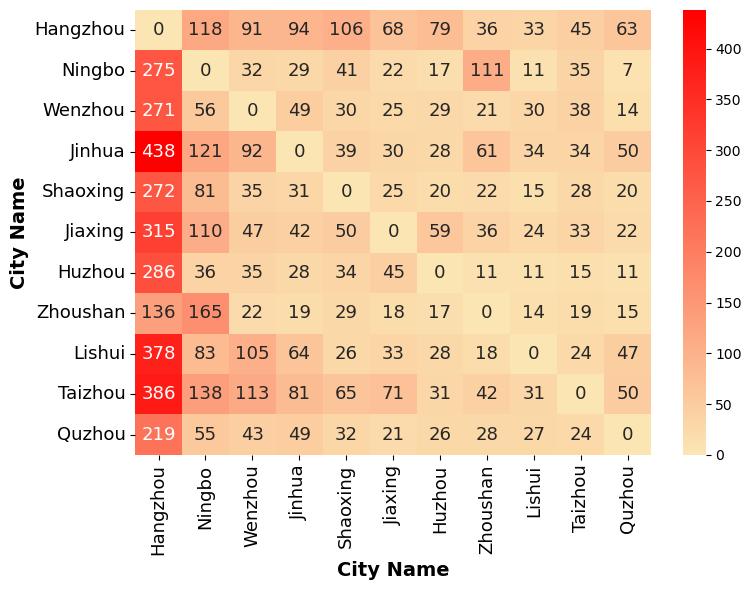

In [13]:
show_citation_heatmap_by_province('浙江省')

# 省内占比（in citation）

In [19]:
def show_barplot(df, name):
    plt.figure(figsize=(8, 6))
    FZ_NUM = 13
    FZ = 14
    
    ax = sns.barplot(x='name', y='rate', data=df, color='#F14629')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=FZ_NUM)
     

    # 设置柱子宽度
    for bar in ax.patches:
        bar.set_width(0.5)  
            
    plt.xticks(rotation=90, ha='right')  
    plt.xlabel('City Name', fontsize=FZ, fontweight='bold')
    plt.ylabel('Ratio', fontsize=FZ, fontweight='bold')
    
    plt.xticks(fontsize=FZ_NUM)
    plt.yticks(fontsize=FZ_NUM)

    sns.despine()
    plt.tight_layout()
    plt.savefig('./地图_QGIS/' + name + '/rate_within_province.pdf', format='pdf', dpi=600)
    plt.show()

In [20]:
# 查看citation 省内占比和全国占比的比例关系
def show_citation_within_province_rate(pro_name):
    df_pro = rank[rank.pro_name==pro_name][['name', 'en_name']]
    cities_list = df_pro['name'].tolist()
    
    temp = df_martix.loc[cities_list, cities_list]
    city_translation = df_pro.set_index('name')['en_name'].to_dict()
    
    datas = []
    for i in cities_list:
        in_citation_nationwide = df_in_out[df_in_out.cityname==i]['in-count'].values[0]
        in_citation_province = sum((temp[i].values))
        
        rate = in_citation_province/in_citation_nationwide
        # print
        print(i, in_citation_province, in_citation_nationwide, rate)
        # 英文城市名称
        datas.append([city_translation.get(i), rate])
        
    df_rate = pd.DataFrame(datas, columns=['name', 'rate'])
    
    show_barplot(df_rate, pro_name)
    return df_rate

杭州市 2976 10219 0.2912222330952148
宁波市 963 3413 0.2821564605918547
温州市 615 1765 0.34844192634560905
金华市 486 1462 0.332421340629275
绍兴市 452 1130 0.4
嘉兴市 358 1085 0.32995391705069127
湖州市 334 864 0.38657407407407407
舟山市 386 814 0.4742014742014742
丽水市 230 679 0.3387334315169367
台州市 295 688 0.42877906976744184
衢州市 299 577 0.5181975736568457


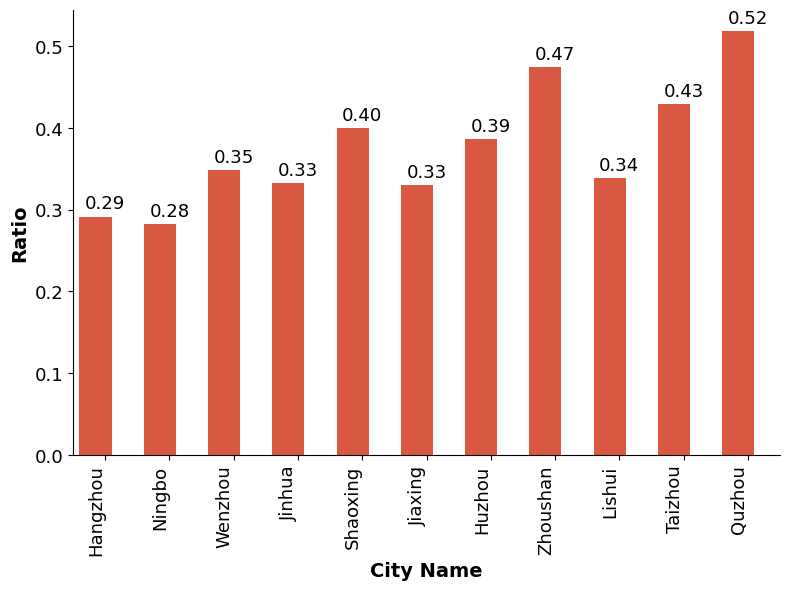

,name,rate
0,Hangzhou,0.291222
1,Ningbo,0.282156
2,Wenzhou,0.348442
3,Jinhua,0.332421
4,Shaoxing,0.400000
5,Jiaxing,0.329954
6,Huzhou,0.386574
7,Zhoushan,0.474201
8,Lishui,0.338733
9,Taizhou,0.428779


In [21]:
show_citation_within_province_rate('浙江省')

# 省内城市（连通性，QGIS）

In [34]:
def inter_city_connectivity_value(cityA, cityB):
    # B城市提及了多少次A
    v_B2A = df_martix.loc[cityB, cityA]
    # A提及了多少次B
    v_A2B = df_martix.loc[cityA, cityB]
    return math.sqrt(v_B2A * v_A2B)

def get_cities_intensity_in_province(pro_name):
    cities = df_citys[df_citys.pro_name==pro_name]['name'].tolist()
    
    datas = []
    for i in cities:
        for j in cities:
            if i != j:
                v = inter_city_connectivity_value(i, j)
                datas.append([i, j, v]) 
    # 边
    temp = pd.DataFrame(datas, columns=['city_a', 'city_b', 'intensity'])
    # 去掉重复的城市对（city_a, city_b）== (city_b, city_a)
    df_sorted = temp.apply(lambda x: sorted([x['city_a'], x['city_b']]), axis=1, result_type='expand')
    df_sorted.columns = ['city1', 'city2']
    temp['city1'] = df_sorted['city1']
    temp['city2'] = df_sorted['city2']
    df_unique = temp.drop_duplicates(subset=['city1', 'city2'])
    df_unique = df_unique.drop(columns=['city1', 'city2'])
    df_unique.to_csv('./地图_QGIS/浙江省/edges.csv', index=None)

    # 节点
    nodes =  rank[rank.pro_name==pro_name][['name', 'en_name', 'pro_name', 'ARI', 'Longitude', 'Latitude']]
    nodes.to_csv('./地图_QGIS/浙江省/nodes.csv', index=None)
    
    return df_unique
    
get_cities_intensity_in_province('浙江省')

,city_a,city_b,intensity
0,舟山市,嘉兴市,25.455844
1,舟山市,宁波市,135.332923
2,舟山市,台州市,28.248894
3,舟山市,温州市,21.494185
4,舟山市,金华市,34.044089
5,舟山市,杭州市,69.971423
6,舟山市,湖州市,13.674794
7,舟山市,丽水市,15.874508
8,舟山市,衢州市,20.493902
9,舟山市,绍兴市,25.258662
